<a href="https://colab.research.google.com/github/akshaypt7/customer_relationship_prediction/blob/main/Kdd_cup_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OrdinalEncoder

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
f2_score = make_scorer(fbeta_score, beta=2)

In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/ML-2 project/data/orange_small_train.data', sep='\t')

In [5]:
df_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,NaN,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.0,580.0,NaN,14.0,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3570.0,NaN,NaN,...,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,210.0,NaN,2.0,24.0,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4764966.0,NaN,NaN,...,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,NaN,NaN,904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212.0,1515.0,NaN,26.0,816.0,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5883894.0,NaN,NaN,...,NaN,eOQt0GoOh3,AERks4l,SEuy,taul,1K8T,ffXs,NldASpP,y4g9XoZ,vynJTq9,smXZ,4bTR,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,NaN,uKAI,L84s,UbxQ8lZ,NaN,TTGHfSv,NaN,pMWAe2U,bHR7,UYBR,FzaX,JFM1BiF,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,22.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,jg69tYsGvO,RO12,NaN,taul,1K8T,ssAy,_ybO0dd,4hMlgkf58mhwh,NaN,NaN,W8mQ,9_Y1,YULl,VpdQ,NaN,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,NaN,kq0dQfu,eKej,UYBR,FzaX,L91KIiz,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,NaN,NaN,3216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,80.0,NaN,4.0,64.0,NaN,NaN,200.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,IXSgUHShse,RO12,SEuy,taul,1K8T,uNkU,EKR938I,ThrHXVS,0v21jmy,smXZ,xklU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,SJs3duv,NaN,11p4mKe,H3p7,UYBR,FzaX,OrnLfvc,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [6]:
y_train_churn = pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_churn.labels', header = None).loc[:, 0].astype('category')
y_train_churn.head()

0   -1
1    1
2   -1
3   -1
4   -1
Name: 0, dtype: category
Categories (2, int64): [-1, 1]

In [7]:
y_train_appetency =pd.read_table('/content/drive/MyDrive/ML-2 project/data/orange_small_train_appetency.labels',header = None).loc[:, 0].astype('category')
y_train_appetency.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: 0, dtype: category
Categories (2, int64): [-1, 1]

In [8]:
y_train_upselling= pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_upselling.labels', header = None).loc[:, 0].astype('category')
y_train_upselling.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: 0, dtype: category
Categories (2, int64): [-1, 1]

In [9]:
df_test = pd.read_table('/content/drive/MyDrive/ML-2 project/data/orange_small_test.data')
df_test.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.0,195.0,NaN,0.0,72.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4259232.0,NaN,NaN,...,NaN,xddq9ayfAo,RO12,NaN,taul,1K8T,PShj,iJzviRg,17VONbZnAuZ90atz,MF5EBmj,NaN,WVvO,9_Y1,vm5R,VpdQ,haYg,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,H4p93_uThXwSG,NaN,XREFJCi,NaN,7WwzJJY,OgPm,cJvF,FzaX,ch2oGfM,Al6ZaUT,P6pu4Vl,LM8l689qOp,NaN,ELof,7P5s,ZI9m,R4y5gQQWY8OodqDV,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,259.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,240.0,NaN,0.0,40.0,NaN,NaN,300.32,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4859550.0,NaN,NaN,...,NaN,cFHt0GoOh3,RO12,NaN,taul,1K8T,lK27,rsmctTK,7ONkRNQCK7,NaN,NaN,aFB2,9_Y1,t_4G,VpdQ,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,4ls8,cJvF,FzaX,Kgofc8E,oslk,S46Rt72,LM8l689qOp,NaN,NaN,Qu4f,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,861.0,14.0,NaN,NaN,NaN,NaN,NaN,236.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,40.0,NaN,0.0,8.0,NaN,NaN,186.64,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,10038840.0,NaN,NaN,...,NaN,zcROj17IEC,RO12,NaN,taul,1K8T,oXaB,I6Bd3iM,bGUqwlz,NaN,NaN,6k5I,9_Y1,iVbl,VpdQ,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJtVhC,0b0w,cJvF,FzaX,bBmOw16,oslk,CcdTy9x,LM8l689qOp,NaN,NaN,7aLG,RAYp,F2FyR07IdsN7I,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1568.0,7.0,NaN,NaN,NaN,NaN,NaN,1232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,448.0,560.0,NaN,4.0,88.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,116760.0,NaN,NaN,...,NaN,gOyq9ayE15,2Knk1KF,SEuy,taul,1K8T,tzKK,Te2s8CN,hOpRIhsUSP,x0xpMjN,smXZ,kVZt,9_Y1,vm5R,VpdQ,6JmL,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,3yoa8Yv,NaN,XTbPUYD,XqfQ,UYBR,AU8pNoi,rDm6pd1,oslk,Q53Rkup,LM8l689qOp,NaN,kG3k,7P5s,RAYp,TCU50_Yjmm6GIBZ0lL_,am7c,NaN
4,NaN,NaN,NaN,NaN,NaN,1197.0,7.0,NaN,NaN,NaN,NaN,NaN,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,125.0,NaN,8.0,40.0,NaN,NaN,133.12,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,257772.0,NaN,NaN,...,NaN,voArjIXt5a,onTuEhrJJQy_H3IHkZku5AFczhYGqxJ890,NaN,taul,1K8T,80HR,fqeOwLG,nJy8d8N5V7yiy,IBmPo7a,NaN,oyu5,9_Y1,WIr3,VpdQ,kxE9,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,H4p93_uThXwSG,NaN,c02HCHI,NaN,_JdEa95,bOvW,cJvF,FzaX,fxJmel6,Al6ZaUT,WfsWw2A,LM8l689qOp,NaN,ELof,5Acm,ZI9m,iyHGyLCEkQ,am7c,NaN


Change the lables from [-1, 1] to [0, 1]

In [10]:
y_train_appetency = (y_train_appetency.astype('int') + 1)/2
y_train_churn = (y_train_churn.astype('int') + 1)/2
y_train_upselling = (y_train_upselling.astype('int') + 1)/2

In [11]:
y_train_appetency.tail()

49995    1.0
49996    1.0
49997    0.0
49998    0.0
49999    0.0
Name: 0, dtype: float64

In [12]:
np.mean(y_train_appetency == 1) , np.mean(y_train_churn == 1) , np.mean(y_train_upselling == 1)

(0.0178, 0.07344, 0.07364)

In [13]:
y_train_churn.value_counts()

0.0    46328
1.0     3672
Name: 0, dtype: int64

In [14]:
y_train_appetency.value_counts()

0.0    49110
1.0      890
Name: 0, dtype: int64

In [15]:
y_train_upselling.value_counts()

0.0    46318
1.0     3682
Name: 0, dtype: int64

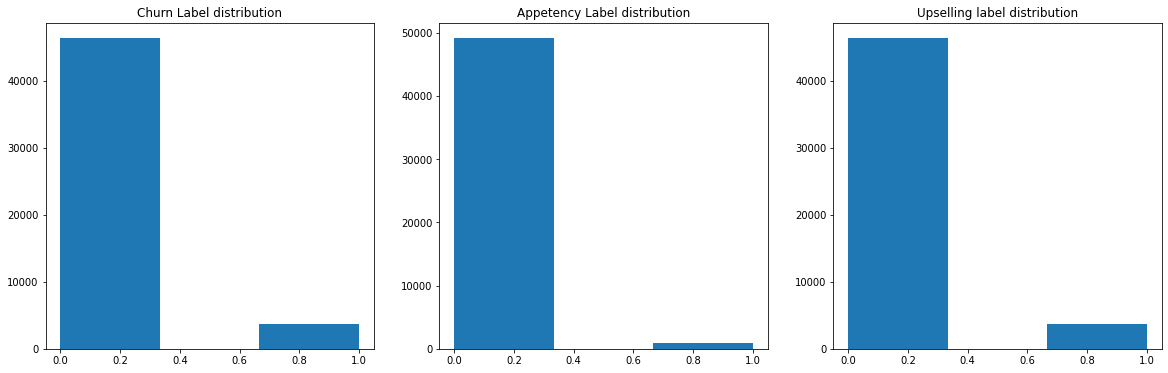

In [16]:
fig, axes = plt.subplots(1,3, figsize=(20,6))
axes[0].hist(y_train_churn, bins=3)
axes[0].set_title('Churn Label distribution')
axes[1].hist(y_train_appetency, bins=3)
axes[1].set_title('Appetency Label distribution')
axes[2].hist(y_train_upselling, bins=3)
axes[2].set_title('Upselling label distribution')
plt.show()

### Preprocessing

In [17]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

In [18]:
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='HC' # high cardinality
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return df[cols]
    return df


In [19]:
pretty_print(tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']))

Table Shape (50000, 230)


,dtype,nulls,num_uniques,value_counts
Var1,float64,49298,19,HC
Var2,float64,48759,3,nan:487590.0:12405.0:1
Var3,float64,48760,147,HC
Var4,float64,48421,5,nan:484210.0:15619.0:1518.0:227.0:1
Var5,float64,48513,572,HC
Var6,float64,5529,1487,HC
Var7,float64,5539,9,7.0:235300.0:13090nan:553914.0:504921.0:182528.0:70335.0:262140.0:142.0:1
Var8,float64,50000,1,nan:50000
Var9,float64,49298,101,HC
Var10,float64,48513,535,HC


Table Shape (50000, 230)


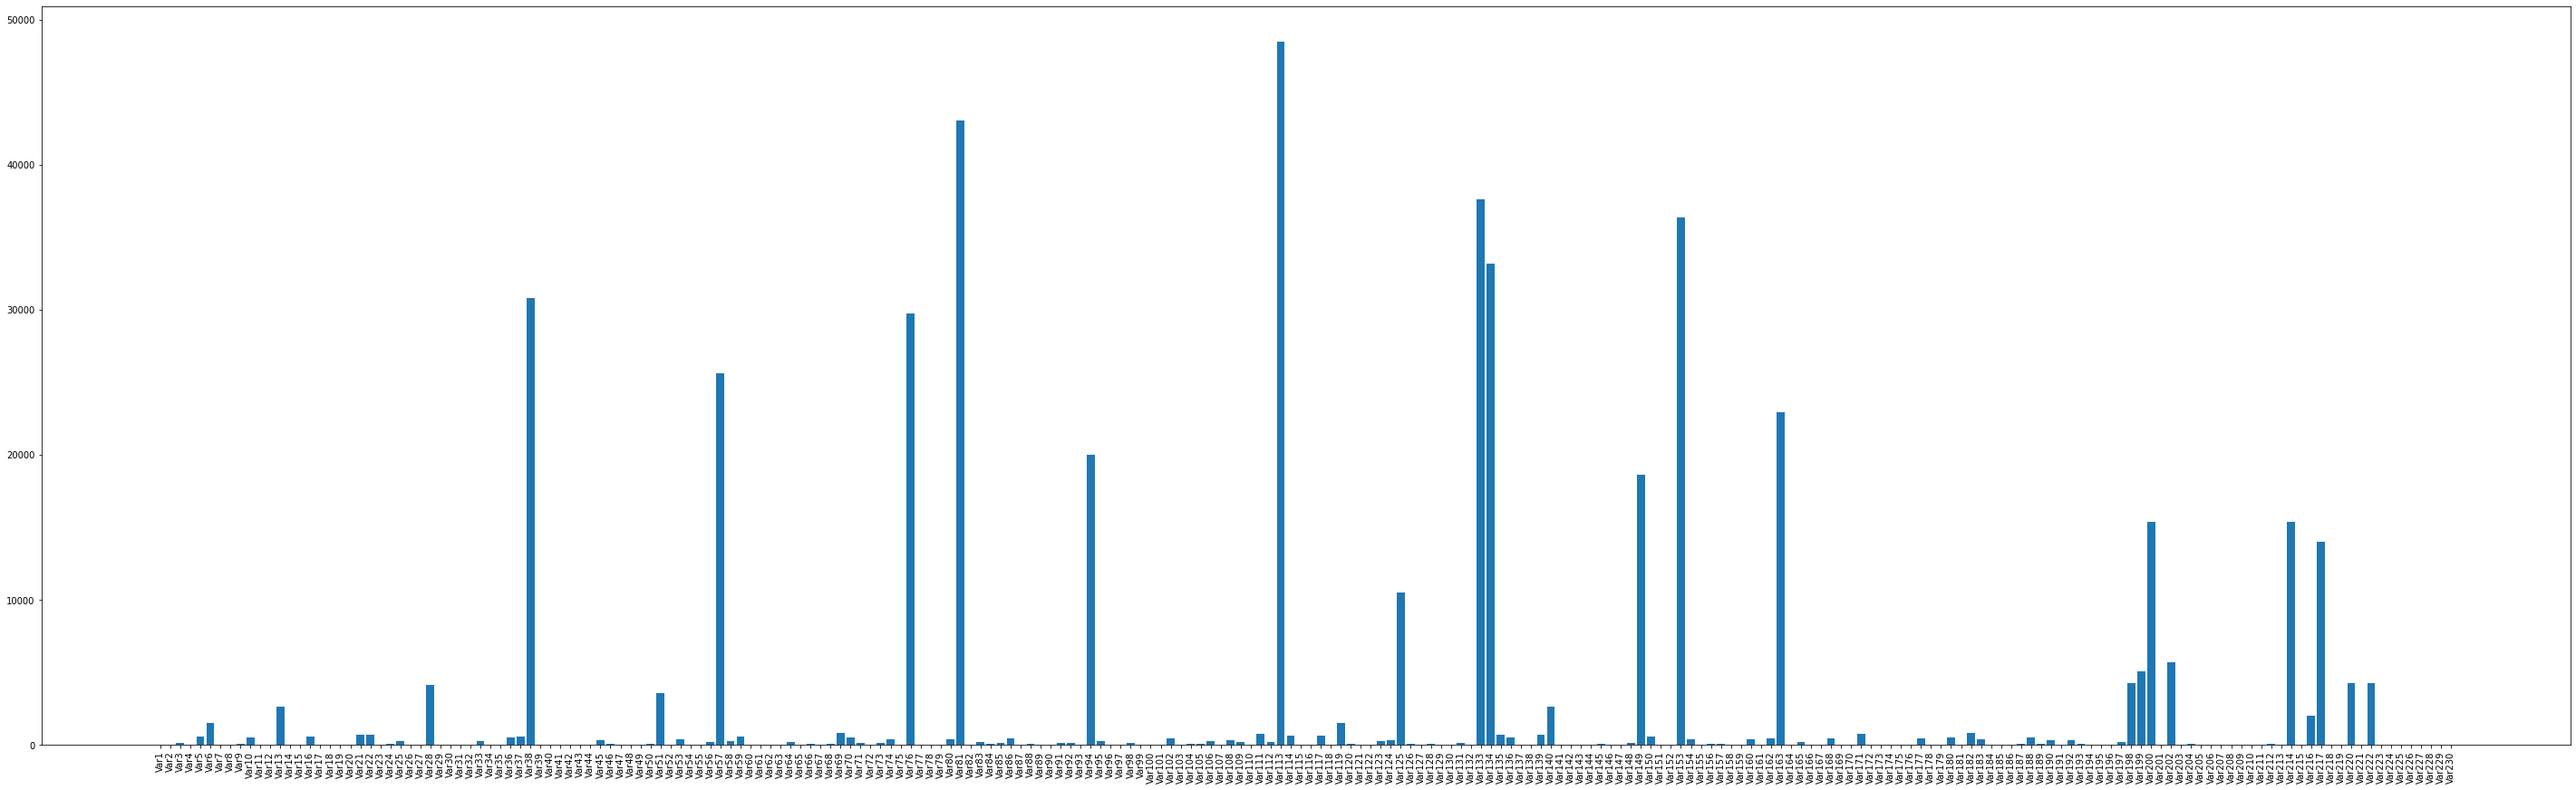

In [20]:
table_report = tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

plt.figure(figsize=(50,15))
plt.bar(table_report.index, table_report['num_uniques'])
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [21]:
df_table = tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']) # Using the second tbl_report function

df_table['dtype'].value_counts()

Table Shape (50000, 230)


float64    191
object      38
int64        1
Name: dtype, dtype: int64

In [22]:
df_float = df_table[df_table['dtype']== 'float64']
lst_empty_float_cols = list(df_float[df_float['nulls'] > len(df_train)*0.95 ].index)
print("Number of float cols where more than 95% of data is null = ",len(lst_empty_float_cols))

Number of float cols where more than 95% of data is null =  149


In [23]:
df_object = df_table[df_table['dtype']== 'object']
lst_empty_categorical_cols = list(df_object[df_object['nulls'] > len(df_train)*0.95 ].index)
print("Number of categorical cols where more than 95% of data is null = ",len(lst_empty_categorical_cols))

Number of categorical cols where more than 95% of data is null =  4


In [24]:
drop_cols = lst_empty_float_cols + lst_empty_categorical_cols
print("Total columns to be dropped =",len(drop_cols))

Total columns to be dropped = 153


In [25]:
df_train_kdd = df_train.drop(drop_cols,axis=1)

In [26]:
categorical_cols = list(df_train_kdd.dtypes[df_train_kdd.dtypes == 'object'].index)
continuous_cols = list(df_train_kdd.dtypes[(df_train_kdd.dtypes == 'float64') | (df_train_kdd.dtypes == 'int64')].index)

In [27]:
df_train_cat_cols = df_train_kdd[categorical_cols].fillna('o')

In [28]:
encoder = OrdinalEncoder()
# transform data
encoder.fit(df_train_cat_cols)
encoded_train_cat_cols = encoder.transform(df_train_cat_cols)

In [29]:
df_train_kdd[categorical_cols] = pd.DataFrame(encoded_train_cat_cols, columns=categorical_cols)


In [30]:
X_train, X_val, y_train, y_val = train_test_split(df_train_kdd, y_train_churn, random_state=66, train_size=0.8, stratify=y_train_churn)


In [31]:
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_train.mean())

In [32]:
X_val.isna().any()

Var6      False
Var7      False
Var13     False
Var21     False
Var22     False
          ...  
Var225    False
Var226    False
Var227    False
Var228    False
Var229    False
Length: 77, dtype: bool

In [33]:
def upsample_downsample(X, y):
    # define oversampling strategy
    over_sample = RandomOverSampler(sampling_strategy=0.2)
    X_over, y_over = over_sample.fit_resample(X, y)

    # define under sampling strategy
    under_sample = RandomUnderSampler(sampling_strategy=0.5)
    X_balanced, y_balanced = under_sample.fit_resample(X_over, y_over)
    return X_balanced, y_balanced

In [34]:
X_train.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var51,Var57,Var65,Var72,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var94,Var109,Var112,Var113,Var119,Var123,Var125,Var126,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var189,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var210,Var211,Var212,Var214,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
35505,343.0,7.0,1488.0,84.0,105.0,2.0,128.0,200.00,0.0,0.0,0.0,42536.253515,5.836574,9.0,4.187324,92,0.0,7904.0,0.0,3694.35,0.0,4.0,99161.216747,16.0,8.0,3364.716,290.0,0.0,2430.0,68.000000,0.0,6995.0,43974.0,1435.0,0.0,9.0,2324.0,102112.0,4.0,6924.0,0.0,0.0,336.000000,209.0,25.0,3.0,22.0,0.0,177.0,3216.0,1291.0,9964.0,1.0,5545.0,0.0,35.0,1.0,18.0,10.0,0.0,5.0,0.0,33.0,685.0,1418.0,4752.0,1.0,11.0,2246.0,4.0,3910.0,0.0,0.0,1.0,2.0,8.0,0.0
28064,1442.0,7.0,792.0,172.0,215.0,6.0,64.0,286.96,0.0,5789556.0,0.0,42536.253515,2.024354,9.0,4.187324,56,168.0,2550296.0,0.0,138998.40,10.0,18.0,99161.216747,88.0,48.0,94877.200,905.0,78.0,92817.0,-30.000000,0.0,1980105.0,1109132.0,635.0,0.0,18.0,1309861.0,10533160.0,10.0,1443474.0,0.0,0.0,270.523569,95.0,25.0,1.0,22.0,0.0,222.0,461.0,1073.0,1938.0,2.0,5134.0,0.0,41.0,1.0,10.0,10.0,0.0,5.0,0.0,44.0,14591.0,6.0,1355.0,1.0,11.0,4059.0,4.0,840.0,3.0,3.0,4.0,2.0,8.0,0.0
27185,1946.0,0.0,0.0,296.0,370.0,2.0,56.0,200.00,0.0,7820820.0,0.0,42536.253515,0.021363,9.0,4.187324,78,0.0,983160.0,0.0,82460.09,40.0,4.0,99161.216747,56.0,72.0,71299.200,1960.0,120.0,7740.0,-0.528886,0.0,1287575.0,532514.0,0.0,0.0,0.0,152208.0,10436720.0,56.0,449868.0,0.0,0.0,138.000000,95.0,25.0,1.0,22.0,0.0,207.0,2641.0,750.0,10135.0,2.0,1940.0,0.0,0.0,0.0,6.0,10.0,0.0,5.0,0.0,33.0,5712.0,1544.0,4598.0,0.0,11.0,3823.0,4.0,2385.0,1.0,1.0,4.0,2.0,8.0,1.0
42938,336.0,7.0,16.0,76.0,95.0,2.0,32.0,200.00,0.0,19914.0,0.0,42536.253515,4.088016,9.0,4.187324,116,0.0,19112.0,0.0,6333.84,0.0,0.0,99161.216747,16.0,16.0,-10617.000,385.0,6.0,5265.0,42.000000,0.0,123910.0,59742.0,25.0,0.0,9.0,1050.0,241444.0,24.0,0.0,0.0,0.0,270.523569,330.0,0.0,1.0,22.0,0.0,217.0,1531.0,3246.0,3100.0,2.0,5022.0,0.0,6.0,0.0,3.0,5.0,0.0,5.0,0.0,18.0,9941.0,212.0,4381.0,0.0,11.0,232.0,3.0,4242.0,0.0,1.0,10.0,4.0,2.0,0.0
7183,203.0,0.0,0.0,20.0,25.0,0.0,16.0,230.56,0.0,881166.0,0.0,42536.253515,3.230506,27.0,9.000000,22,0.0,0.0,0.0,190752.30,0.0,0.0,405183.000000,0.0,0.0,-111240.800,215.0,6.0,0.0,-2.000000,0.0,3490395.0,2388380.0,0.0,0.0,9.0,0.0,8156520.0,4.0,0.0,0.0,0.0,270.523569,135.0,25.0,3.0,22.0,0.0,64.0,1844.0,1191.0,12515.0,1.0,5610.0,0.0,36.0,1.0,21.0,10.0,0.0,5.0,1.0,33.0,12581.0,180.0,5862.0,0.0,11.0,2502.0,4.0,2859.0,0.0,2.0,12.0,2.0,8.0,2.0


In [35]:
X_balanced, y_balanced = upsample_downsample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [36]:
X_balanced = pd.DataFrame(X_balanced,columns=X_train.columns)

In [37]:
cont_cols_df_X = X_balanced[continuous_cols]

###Standard Scaler

In [38]:
scaler = StandardScaler()
scaler.fit(cont_cols_df_X)
scaled_X_balanced = scaler.transform(cont_cols_df_X)

In [39]:
X_balanced_scaled = pd.DataFrame(scaled_X_balanced,columns=continuous_cols).join(X_balanced[categorical_cols])
X_balanced_scaled.columns = X_balanced.columns

In [40]:
X_val = X_val.reset_index().drop('index', axis=1)

In [41]:
X_val_scaled = pd.DataFrame(scaler.transform(X_val[continuous_cols])).join(X_val[categorical_cols])
X_val_scaled.columns = X_balanced.columns

In [42]:

!pip install rfpimp
from rfpimp import plot_corr_heatmap, plot_dependence_heatmap, feature_dependence_matrix, feature_corr_matrix

  Created wheel for rfpimp: filename=rfpimp-1.3.7-cp37-none-any.whl size=10670 sha256=f0c74af46686cedcc4d36f62ba033c2ac00536011b7fa7782570994aed2d7ac6
  Stored in directory: /root/.cache/pip/wheels/16/08/23/9d90df482c9c943df4d6fe874c0937f8e81dc3db917c9300c2
Successfully built rfpimp


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


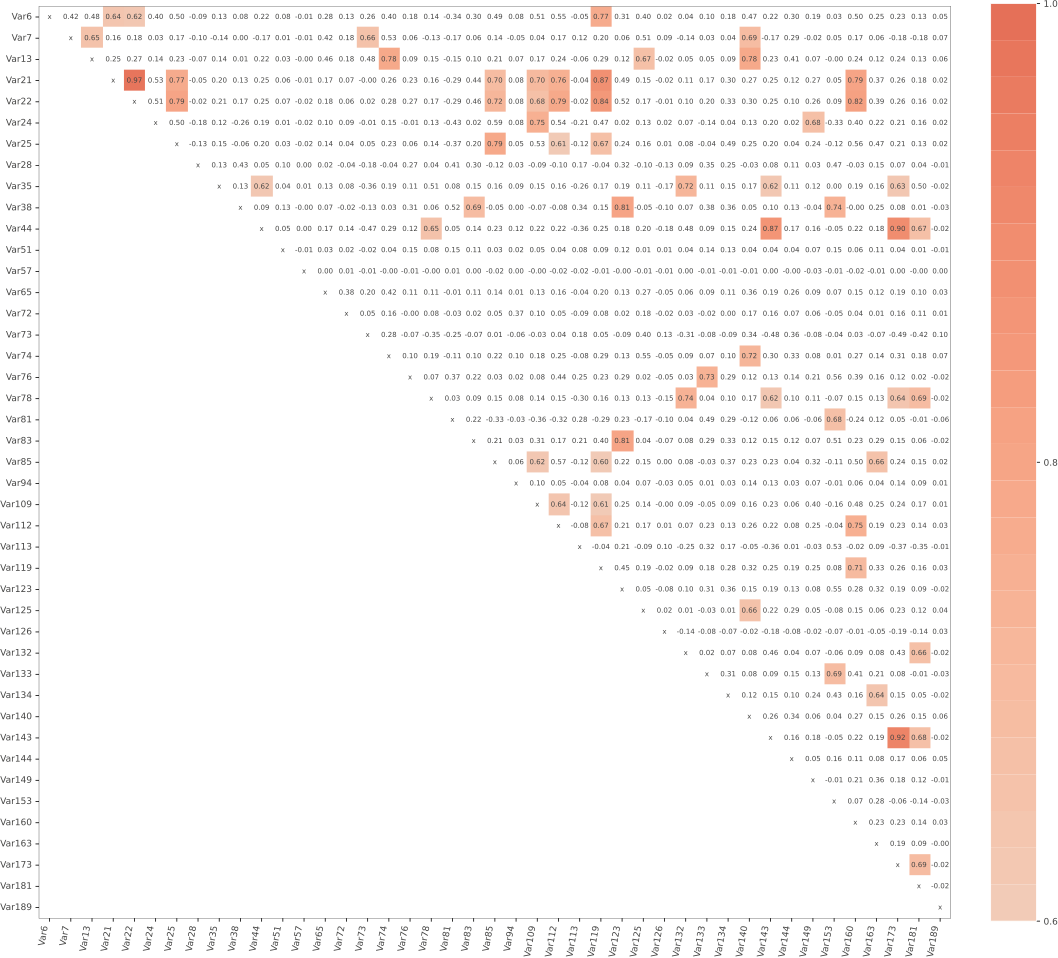

In [43]:
viz = plot_corr_heatmap(X_balanced_scaled[continuous_cols], figsize=(15,15), label_fontsize=9, value_fontsize=7)
viz

In [44]:
corr_matrix = feature_corr_matrix(X_balanced_scaled).abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

# Drop features 
len(to_drop)

17

In [45]:
X_balanced_scaled.drop(to_drop, axis=1, inplace=True)
X_val_scaled.drop(to_drop, axis=1, inplace=True)

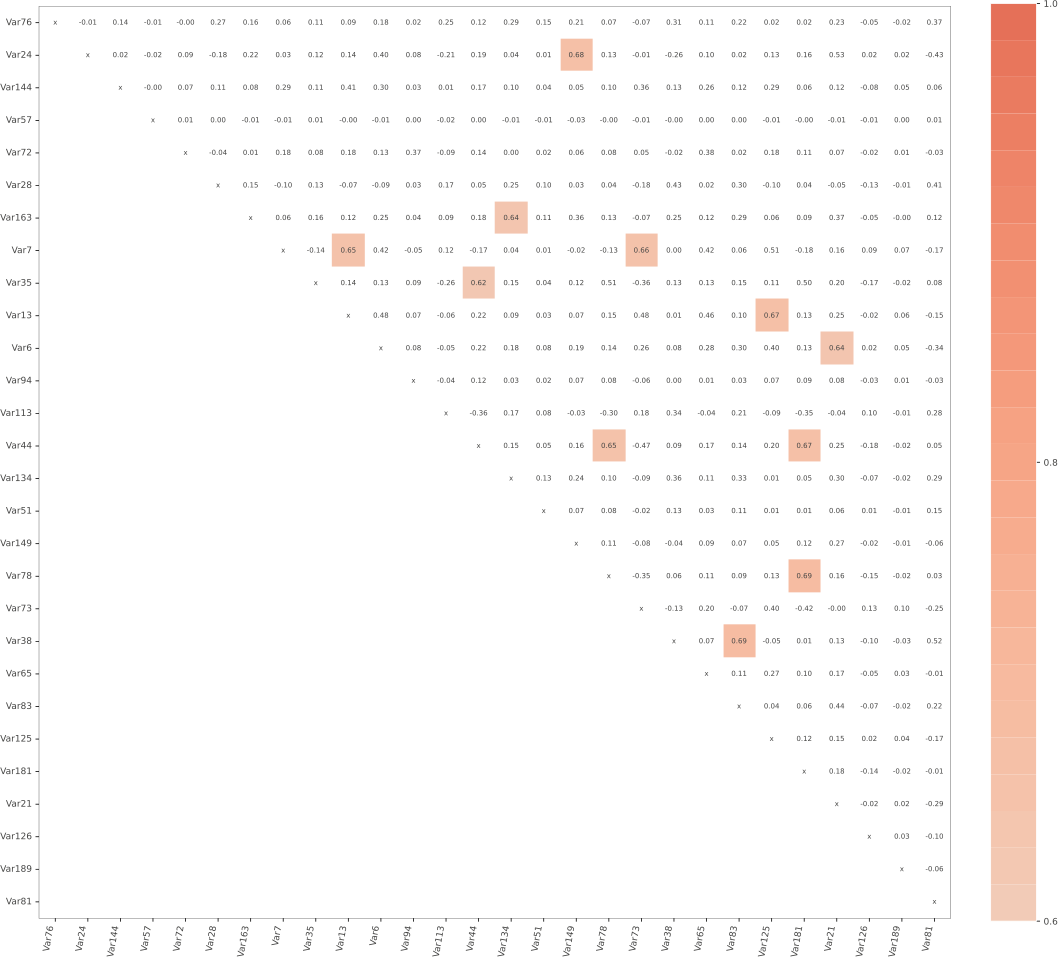

In [46]:
viz = plot_corr_heatmap(X_balanced_scaled[set(continuous_cols) - set(to_drop)], figsize=(15,15), label_fontsize=9, value_fontsize=7)
viz

###Modeling

In [47]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        print("SCORE FUNC", score_func)
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best

In [48]:
def do_classify(clf, parameters, X_train, y_train, X_val, y_val, 
                featurenames, 
                score_func, n_folds=5, n_jobs=-1):
    if parameters:
        clf = cv_optimize(clf, parameters, X_train, y_train, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    val_score = clf.score(X_val, y_val)
    print("############# based on standard predict 0.5 ################")
    print("ROC AUC score on training data: %0.2f" % (train_score))
    print("ROC AUC precision score on validation data:     %0.2f" % (val_score))
    print(confusion_matrix(y_val, clf.predict(X_val)))
    print("########################################################")
    return clf, dict(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

In [264]:
rf = RandomForestClassifier(warm_start=True, oob_score=True, n_jobs=-1, random_state=66)

In [265]:
param_grid_rf = { "n_estimators": range(500,1000, 100), "max_depth": range(5,9)}

In [266]:
  rf, _  = do_classify(rf, param_grid_rf, X_balanced_scaled, y_balanced, X_val_scaled, y_val.values, X_balanced_scaled.columns, score_func='roc_auc')

SCORE FUNC roc_auc
BEST {'max_depth': 8, 'n_estimators': 900} 0.8054252185782842


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


############# based on standard predict 0.5 ################
ROC AUC score on training data: 0.75
ROC AUC precision score on validation data:     0.91
[[8946  320]
 [ 623  111]]
########################################################


In [6]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5,  proba=True, skip=0, initial = False):
    if not ax:
        ax=plt.gca()
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe+10):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

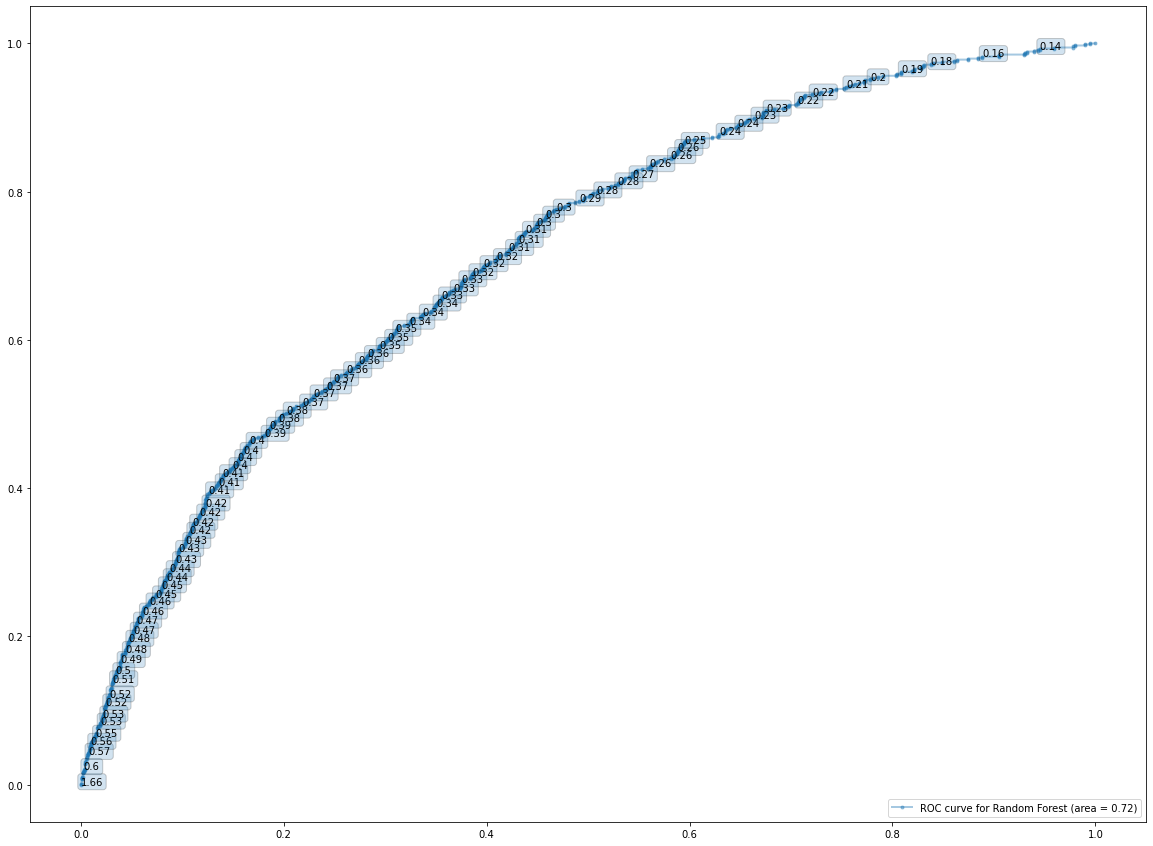

In [286]:
plt.figure(figsize=(20,15))
make_roc('Random Forest', rf, y_val, X_val_scaled)

In [287]:
rf_model_filename = '/content/drive/MyDrive/UnivAI/ML-2 project/model/rf_model_900.pickle'
pickle.dump(rf, open(rf_model_filename, 'wb'))

In [288]:
rf = pickle.load(open(rf_model_filename, 'rb'))

# New Section

In [290]:
param_grid_rf_max_features = {'max_features': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]}

In [291]:
rf_est = RandomForestClassifier(n_estimators=900, max_depth=8, warm_start=True, oob_score=True, n_jobs=-1, random_state=66)

In [292]:
rf_est, _  = do_classify(rf_est, param_grid_rf_max_features, X_balanced_scaled, y_balanced, X_val_scaled, y_val.values, X_balanced_scaled.columns, score_func='roc_auc')

SCORE FUNC roc_auc
BEST {'max_features': 0.15} 0.8070630348957895


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


############# based on standard predict 0.5 ################
ROC AUC score on training data: 0.76
ROC AUC precision score on validation data:     0.90
[[8877  389]
 [ 607  127]]
########################################################


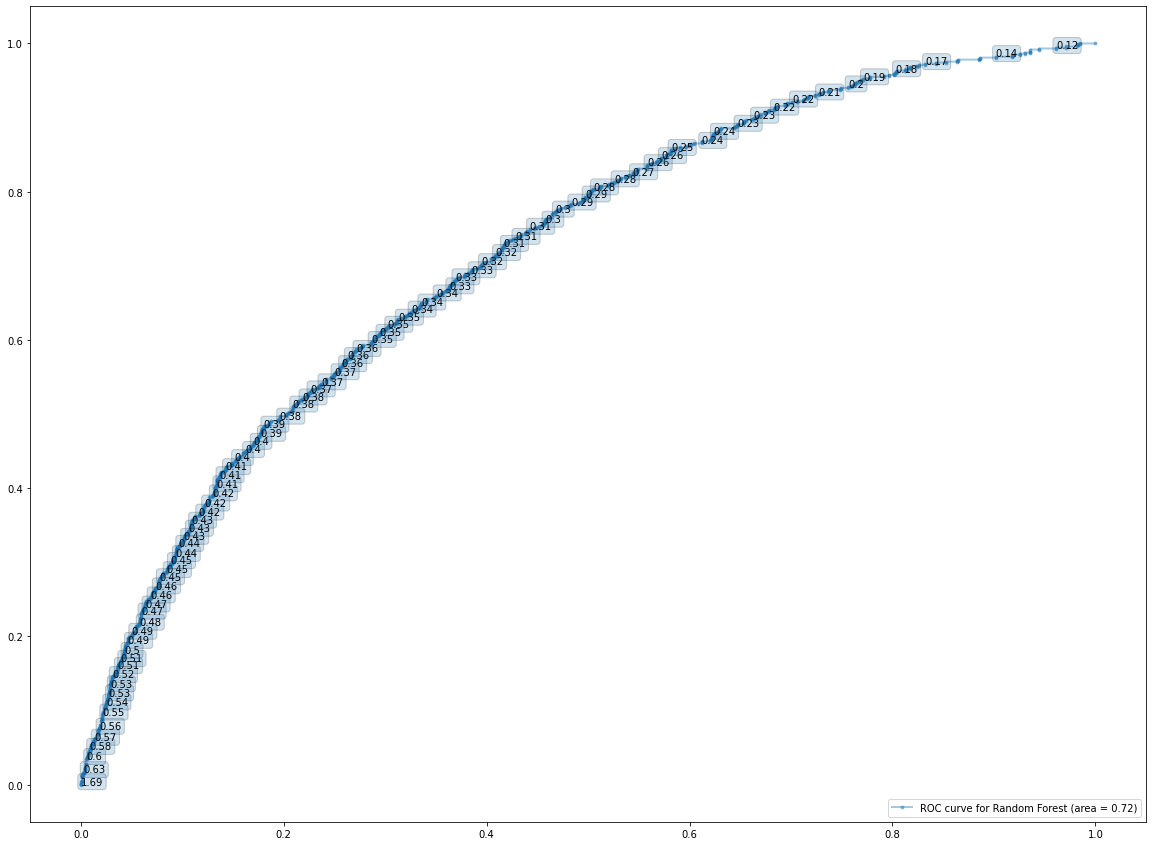

In [295]:
plt.figure(figsize=(20,15))
make_roc('Random Forest', rf_est, y_val, X_val_scaled)

In [296]:
precision, recall, tresholds = precision_recall_curve(y_val, rf_est.predict(X_val_scaled))
auc(recall, precision)

0.23992427708425743

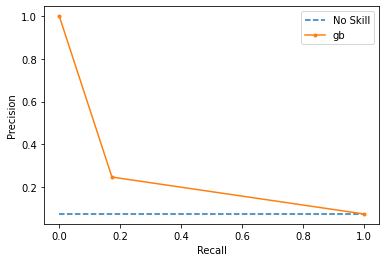

In [294]:
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='gb')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [297]:
rf_more_est = RandomForestClassifier(warm_start=True, oob_score=True, n_jobs=-1, random_state=66)

In [298]:
param_grid_rf_more_est = { "n_estimators": range(1000,3000,300), "max_depth": range(1,10)}

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

In [299]:
rf_more_est, _  = do_classify(rf_more_est, param_grid_rf_more_est, X_balanced_scaled, y_balanced, X_val_scaled, y_val.values, X_balanced_scaled.columns, score_func='roc_auc')

SCORE FUNC roc_auc
BEST {'max_depth': 9, 'n_estimators': 2800} 0.8352006097744459


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


############# based on standard predict 0.5 ################
ROC AUC score on training data: 0.78
ROC AUC precision score on validation data:     0.90
[[8920  346]
 [ 620  114]]
########################################################


In [300]:
rf_model_est_filename = '/content/drive/MyDrive/UnivAI/ML-2 project/model/rf_model_es_3000.pickle'
pickle.dump(rf_more_est, open(rf_model_est_filename, 'wb'))

In [4]:
rf_more_est = pickle.load(open('/content/drive/MyDrive/UnivAI/ML-2 project/model/rf_model_es_3000.pickle', 'rb'))

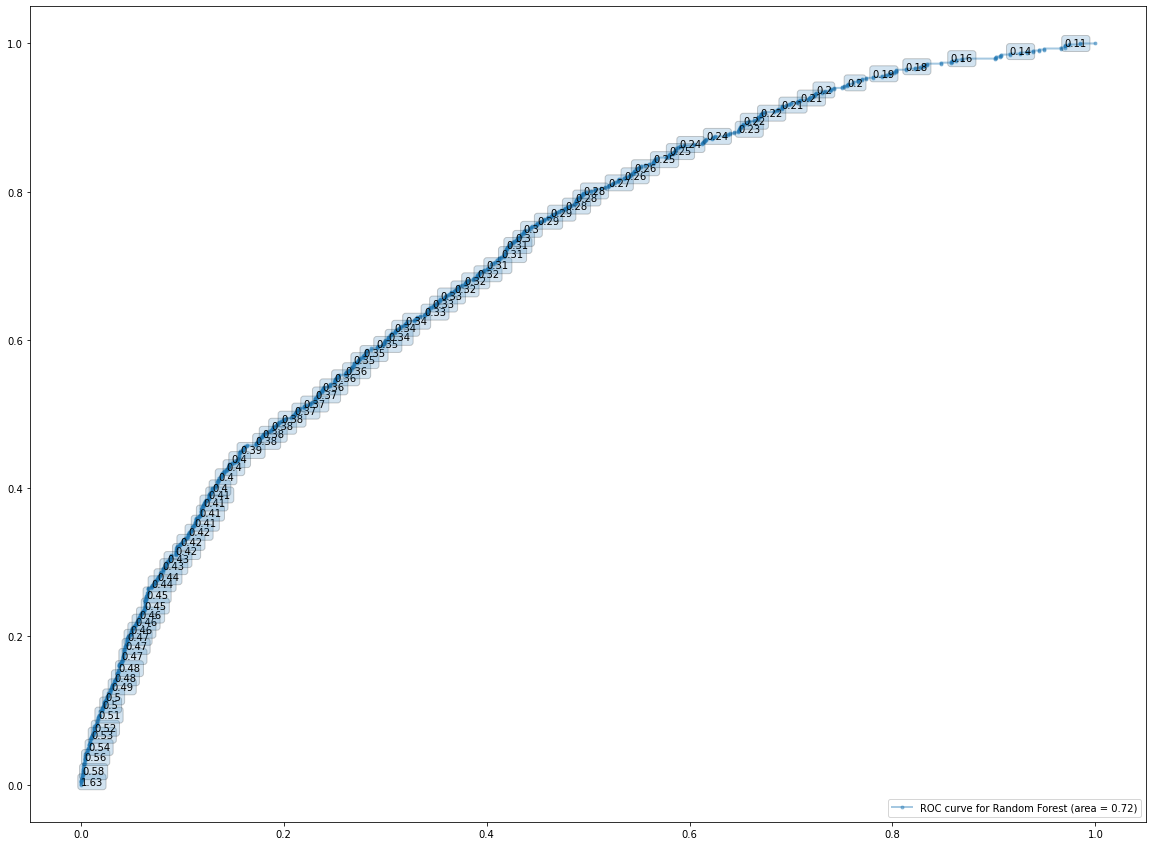

In [54]:
plt.figure(figsize=(20,15))
make_roc('Random Forest', rf_more_est, y_val, X_val_scaled)

In [57]:
precision, recall, tresholds = precision_recall_curve(y_val, rf_more_est.predict(X_val_scaled))
auc(recall, precision)

0.22515508330727657

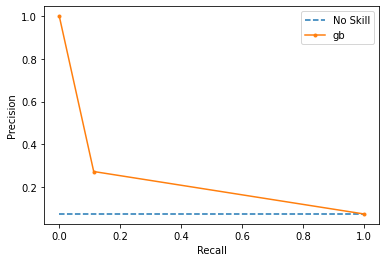

In [58]:
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='gb')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [59]:
rf_more_est_f = RandomForestClassifier(max_depth=9, n_estimators=2800, warm_start=True, oob_score=True, n_jobs=-1, random_state=66)

In [60]:
rf_more_est_f, _  = do_classify(rf_more_est_f, {'max_features': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]}, X_balanced_scaled, y_balanced, X_val_scaled, y_val.values, X_balanced_scaled.columns, score_func='roc_auc')

SCORE FUNC roc_auc
BEST {'max_features': 0.15} 0.8295201383871589


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


############# based on standard predict 0.5 ################
ROC AUC score on training data: 0.78
ROC AUC precision score on validation data:     0.90
[[8888  378]
 [ 609  125]]
########################################################


In [53]:
param_grid_rf_model = {'min_samples_split':range(2, 10), 'min_samples_leaf':range(1,10)}


In [54]:
rf_model = RandomForestClassifier(n_estimators=900, max_depth=8,max_features=0.15,  warm_start=True, oob_score=True, n_jobs=-1, random_state=66)

In [55]:
rf_model, _  = do_classify(rf_model, param_grid_rf_model, X_balanced_scaled, y_balanced, X_val_scaled, y_val.values, X_balanced_scaled.columns, score_func='roc_auc')

SCORE FUNC roc_auc


KeyboardInterrupt: ignored